<a href="https://colab.research.google.com/github/Bayramova/license_plate_recognition/blob/main/license_plate_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подготовка данных:

In [ ]:
# !unzip /content/drive/MyDrive/OCR/CCPD2019-dl1.zip

In [ ]:
img_dir = "/content/CCPD2019-dl1"

In [ ]:
import os

import cv2
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class LicencePlateDataset(Dataset):
  def __init__(self, path, train=True, transform=None):
    super().__init__()
    self.img_dir = os.path.join(path, "train" if train else "test") 
    self.images = [os.path.join(self.img_dir, img_filename) for img_filename in os.listdir(self.img_dir)]
    self.labels = [img_filename.split("-")[-1][:-4] for img_filename in self.images]
    self.transform = transform
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = cv2.imread(self.images[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if self.transform:
      img = self.transform(img)
    label = self.labels[idx]
    return img, label

In [ ]:
train_dataset = LicencePlateDataset(path=img_dir, train=True, transform=transforms.ToTensor())
test_dataset = LicencePlateDataset(path=img_dir, train=False, transform=transforms.ToTensor())

print(f"Number of images in train set: {len(train_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")

Number of images in train set: 199980
Number of images in test set: 9999


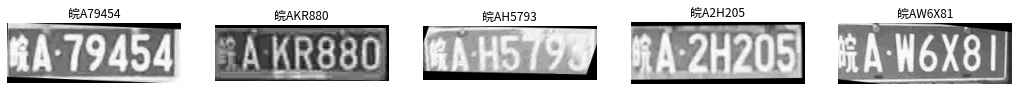

In [ ]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# the following code applies Chinese font to matplotlib
def change_matplotlib_font(font_download_url):
    FONT_PATH = "chinese_font"
    
    font_download_cmd = f"wget {font_download_url} -O {FONT_PATH}.zip"
    unzip_cmd = f"unzip -o {FONT_PATH}.zip -d {FONT_PATH}"
    os.system(font_download_cmd)
    os.system(unzip_cmd)
    
    font_files = fm.findSystemFonts(fontpaths=FONT_PATH)
    for font_file in font_files:
        fm.fontManager.addfont(font_file)

    font_name = fm.FontProperties(fname=font_files[0]).get_name()
    matplotlib.rc("font", family=font_name)

font_download_url = "https://fonts.google.com/download?family=Noto%20Sans%20SC"
change_matplotlib_font(font_download_url)

ids = np.random.randint(low=0, high=len(train_dataset), size=5)
plt.figure(figsize=(18, 6))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(train_dataset[ids[i]][0].squeeze(), cmap="gray")
  plt.title(train_dataset[ids[i]][1])
  plt.axis("off")